# Определение перспективного тарифа для телеком-компании

В нашем распоряжении данные компании "Мегалайн" - федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Примечание**

«Мегалайн» **всегда округляет секунды до минут, а мегабайты — до гигабайт**. Каждый **звонок округляется отдельно**: даже если он длился **всего 1 секунду**, будет засчитан **как 1 минута**.
Для веб-трафика отдельные сессии не считаются. Вместо этого **общая сумма за месяц округляется в бо́льшую сторону**. Если **абонент использует 1025 мегабайт** в этом месяце, с него **возьмут плату за 2 гигабайта**. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

## Изучение данных из файла

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math # для округления в большую сторону по информации, данной при работе над проектом

Сохраняем файлы в говорящие для них переменные:

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

**Посмотрим на таблицы по порядку**

###  Начнем с таблицы с данными о звонках - calls

In [3]:
calls.head(15)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Таблица **calls** (информация о звонках):
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

In [4]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


#### Исправления

* Заметили, что в колонке `id` тип данных строковый (нужно заменить);
* Заметили, что данные в столбце `call_date` записан в формате datetime, но тип данных как строковый;
* Исходя из информации, данной нам в `примечании`, нужно округлить длительность звонков с какими-либо секундами в большую сторону;
* В данных мы нашли звонки с нулевой продолжительностью. Исходя из информации, данной нам в задании, это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять

### На очереди таблица c интернетом - internet

In [6]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Таблица **internet** (информация об интернет-сессиях):
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


#### Исправления

* В колонке `session_date` видим всю ту же проблему. Нужно привести в тип данных соответствующий записи;
* В колонке `id` тип данных строковый (нужно заменить);
* Для чего столбец `Unnamed: 0`  не совсмем понятно, мне кажется, что стоит удалить(но могу ошибаться);
* Снова исходя из `примечания`, стоит окргулить в большую сторону мегaбайты интернета - колонка `mb_used`

### Следующая таблица с сообщениями - messages: 

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


#### Исправления

* Тут не меняются исправления, так же, как и в других таблиц, изменить тип данный в колонке **`message_date`** и **`id`**

Таблица **messages** (информация о сообщениях):
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

### Таблицы с тарифами - tariffs

**ОПИСАНИЕ ТАРИФОВ**

Тариф **`«Смарт»`**

* Ежемесячная плата: `550` рублей
* Включено `500 минут` разговора, `50 сообщений` и `15 Гб` интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    
    `минута` разговора: `3` рубля
    `сообщение`: `3` рубля
* `1 Гб` интернет-трафика: `200` рублей

Тариф **`«Ультра»`**

* `Ежемесячная` плата: `1950` рублей;
* Включено `3000 минут разговора`, `1000 сообщений` и `30 Гб` интернет-трафика;
* Стоимость услуг сверх тарифного пакета:
    
    `минута разговора`: `1` рубль
    `сообщение`: `1` рубль
* `1 Гб` интернет-трафика: `150` рублей


In [11]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица **tariffs** (информация о тарифах):
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [13]:
tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


#### Исправления 

В колонке с тарифами мы не заметили никаких проблем на данном этапе

### Крайняя таблица с пользователями - users

In [14]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Таблица **users** (информация о пользователях):
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [16]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


#### Исправления

* Есть пропущенные значения в колонке `churn_date`;
* Снова наблюдаем не соответствующий тип данных в колонках `churn_date` и `reg_date`

### ВЫВОД 

* Мы открыли файлы данных и прочитали их; 
* На данном этапе мы прошлись по всем колонкам наших таблиц и выявили некоторые недочеты, которые последуют к исправлению

## Предобработка данных

### Calls

In [17]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


* Исправляем все то, что описали при просмотре таблицы:

In [18]:
calls['id'] = calls['id'].astype('int') # изменили тип данных
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y %m %d') # изменили тип данных на соответсвующий 
#calls['duration'] = math.ceil(calls['duration'])

In [19]:
def my_func_ceil(i): # добавляем функцию для округления в сторону большего значения
    return math.ceil(i) #  метод math.ceil(float) окргуляет данные в большую сторону

calls['duration'] = calls['duration'].apply(my_func_ceil)
calls['duration'] = calls['duration'].astype('int') # все так, как опсиано в исправлении
calls.head() 
#calls.info() провели порядок выполнения исправлений 

,id,call_date,duration,user_id
0,10000,2018-07-25,0,1000
1,10001,2018-08-17,0,1000
2,10002,2018-06-11,3,1000
3,10003,2018-09-21,14,1000
4,10004,2018-12-15,6,1000


In [20]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [21]:
calls.duplicated().sum()

0

### internet

In [22]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [23]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y %m %d')
internet['id'] = internet['id'].astype('int')
internet = internet.drop(columns='Unnamed: 0').reset_index(drop=True) # удаляем колонку по нашему предположению и сохраянем порядок

In [24]:
internet['mb_used'] = internet['mb_used'].apply(my_func_ceil) # округляем с помощью уже проделанной функции

In [25]:
internet.head()
#internet.info()

,id,mb_used,session_date,user_id
0,10000,113,2018-11-25,1000
1,10001,1053,2018-09-07,1000
2,10002,1198,2018-06-25,1000
3,10003,551,2018-08-22,1000
4,10004,303,2018-09-24,1000


In [26]:
internet.isna().sum()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [27]:
internet.duplicated().sum()

0

### messages

In [28]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [29]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y %m %d')
messages['id'] = messages['id'].astype('int')

In [30]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  int64         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


In [31]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [32]:
messages.duplicated().sum()

0

### users

In [33]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [34]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y %m %d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y %m %d')

В таблице **tariffs** колонка с тарифами названа **tariff_name**. Для удобства переименуем здесь на такое же название:

In [35]:
users = users.rename(columns={'tariff': 'tariff_name'})
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [36]:
users.isna().sum()

user_id          0
age              0
churn_date     462
city             0
first_name       0
last_name        0
reg_date         0
tariff_name      0
dtype: int64

In [37]:
mean_churn = users['churn_date'].isna().mean()
print(f'Доля действующих тарифов на момент выгрузки данных составляет: {mean_churn:.0%}')

Доля действующих тарифов на момент выгрузки данных составляет: 92%


* Как было указано ранее, если значение пропущено в столбце `churn_date` **NaN**, то тариф ещё действовал на момент выгрузки данных

In [38]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      500 non-null    int64         
 1   age          500 non-null    int64         
 2   churn_date   38 non-null     datetime64[ns]
 3   city         500 non-null    object        
 4   first_name   500 non-null    object        
 5   last_name    500 non-null    object        
 6   reg_date     500 non-null    datetime64[ns]
 7   tariff_name  500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [39]:
users.duplicated().sum()

0

### Для каждого пользователя считаем:

* Количество сделанных звонков и израсходованных минут разговора по месяцам;
* Количество отправленных сообщений по месяцам;
* Объем израсходованного интернет-трафика по месяцам;
* Помесячную выручку с каждого пользователя (нужно вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;  остаток умножить на значение из тарифного плана; прибавить абонентскую плату, соответствующую тарифному плану)


#### Кол-во сделланых звонков и израсходованных минут разговора по месяцам

* Для начала создаем новую колонку с месяцами **month** в таблице звонков **calls**. С пмощью метода `dt.month` создаем из нужной колонки новую с месяцем;

In [40]:
calls.head()

,id,call_date,duration,user_id
0,10000,2018-07-25,0,1000
1,10001,2018-08-17,0,1000
2,10002,2018-06-11,3,1000
3,10003,2018-09-21,14,1000
4,10004,2018-12-15,6,1000


In [41]:
calls['month'] = calls['call_date'].dt.month
calls.head()

,id,call_date,duration,user_id,month
0,10000,2018-07-25,0,1000,7
1,10001,2018-08-17,0,1000,8
2,10002,2018-06-11,3,1000,6
3,10003,2018-09-21,14,1000,9
4,10004,2018-12-15,6,1000,12


* Теперь методом `pivot_table()` объединяем строки колонок **'user_id', 'month'** и выводим значение по длительности `'duration'` с добавлением функции подсчета кол-ва `count` и суммы `sum`: 

In [42]:
calls_month = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
#calls_month = calls_month.rename(columns={'duration': 'кол-во звонков', 'duration': 'длительность звонков'})
calls_month.columns = ['кол-во звонков', 'длительность звонков(мин)']
calls_month.reset_index(inplace=True) # сохраняем колонку 'month' в новом датафрейме
calls_month.head(15)

,user_id,month,кол-во звонков,длительность звонков(мин)
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
5,1000,10,57,350
6,1000,11,43,338
7,1000,12,46,333
8,1001,11,59,430
9,1001,12,63,414


In [43]:
calls_month.loc[275, 'кол-во звонков'] = np.NaN

In [44]:
calls_month.query('month == 1').count()

user_id                      43
month                        43
кол-во звонков               42
длительность звонков(мин)    43
dtype: int64

#### Количество отправленных сообщений по месяцам

* Алгоритм действия схож со звонками таблицы **calls**. Сначала мы создаем новый столбец с месяцами **'month'**, затем создаем сводную таблицу по уникальному номеру сообщения **'id'**, проходясь по строчкам идентификатора пользователя и месяца **'user_id', 'month'**

In [45]:
messages.head()

,id,message_date,user_id
0,10000,2018-06-27,1000
1,10001,2018-10-08,1000
2,10002,2018-08-04,1000
3,10003,2018-06-16,1000
4,10004,2018-12-05,1000


In [46]:
messages['month'] = messages['message_date'].dt.month
messages_month = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
#messages_month.head()
messages_month.columns = ['кол-во смс за месяц']
messages_month.reset_index(inplace=True)
messages_month.head(15)

,user_id,month,кол-во смс за месяц
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


#### Объем израсходованного интернет-трафика по месяцам

* Выполняем все то же самое, исходя из данных об интернете **internet**

In [47]:
internet.head()

,id,mb_used,session_date,user_id
0,10000,113,2018-11-25,1000
1,10001,1053,2018-09-07,1000
2,10002,1198,2018-06-25,1000
3,10003,551,2018-08-22,1000
4,10004,303,2018-09-24,1000


In [48]:
internet['month'] = internet['session_date'].dt.month
internet_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_month.columns = ['израсходованный интернет(мб)'] # указываем трафик интернета в мб - Мегабайтах
internet_month.reset_index(inplace=True)
internet_month.head(15)

,user_id,month,израсходованный интернет(мб)
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
5,1000,10,14717
6,1000,11,14768
7,1000,12,9827
8,1001,11,18452
9,1001,12,14053


#### Помесячная выручка с каждого пользователя

* Нужно вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
* Остаток умножить на значение из тарифного плана; 
* Прибавить абонентскую плату, соответствующую тарифному плану

Сначала объединяем столбцы методом `merge()` по очереди (звонки с сообщениями, с интернетом, с пользоватьелями, с тарифом):

In [49]:
#money = calls_month.join(['messages_month', 'internet_month'], on=['user_id', 'month'], how='outer')
money = calls_month.merge(messages_month, on=['user_id', 'month'], how='outer') # how='outer' объединяет область, 
                                                                        # где есть данные хотя бы в одном из стобцов
money.head()

,user_id,month,кол-во звонков,длительность звонков(мин),кол-во смс за месяц
0,1000,5,22.0,159.0,22.0
1,1000,6,43.0,172.0,60.0
2,1000,7,47.0,340.0,75.0
3,1000,8,52.0,408.0,81.0
4,1000,9,58.0,466.0,57.0


In [50]:
money = money.merge(internet_month, on=['user_id','month'], how='outer')
money.head()

,user_id,month,кол-во звонков,длительность звонков(мин),кол-во смс за месяц,израсходованный интернет(мб)
0,1000,5,22.0,159.0,22.0,2256.0
1,1000,6,43.0,172.0,60.0,23257.0
2,1000,7,47.0,340.0,75.0,14016.0
3,1000,8,52.0,408.0,81.0,14070.0
4,1000,9,58.0,466.0,57.0,14581.0


In [51]:
money = money.merge(users, on='user_id', how='left') # делаем параметр how='left', чтобы точно присутствовали значения из
                                                    # левого датафрейма
money.head()

,user_id,month,кол-во звонков,длительность звонков(мин),кол-во смс за месяц,израсходованный интернет(мб),age,churn_date,city,first_name,last_name,reg_date,tariff_name
0,1000,5,22.0,159.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,172.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,340.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,408.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,466.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [52]:
money = money.merge(tariffs, on='tariff_name',  how='left')
money.head()

,user_id,month,кол-во звонков,длительность звонков(мин),кол-во смс за месяц,израсходованный интернет(мб),age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,172.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,340.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,408.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,466.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [53]:
money.isna().sum()
#money.describe()
#money.info()

user_id                            0
month                              0
кол-во звонков                    41
длительность звонков(мин)         40
кол-во смс за месяц              497
израсходованный интернет(мб)      11
age                                0
churn_date                      3027
city                               0
first_name                         0
last_name                          0
reg_date                           0
tariff_name                        0
messages_included                  0
mb_per_month_included              0
minutes_included                   0
rub_monthly_fee                    0
rub_per_gb                         0
rub_per_message                    0
rub_per_minute                     0
dtype: int64

Теперь имеем датафрейм со всеми значениями, которые хранятся в переменной **money**. Пропуски в колонках с кол-во звонками, с их длительностью, с кол-во смс за месяц и с израсходованным интернетом - это не использование данных услуг. 

`Избавляемся от пропусков в этих столбцах, путем заменой на 0` - **не использовано**:

In [54]:
money.loc[:, 'кол-во звонков': 'израсходованный интернет(мб)'] = money.loc[:, 'кол-во звонков': 'израсходованный интернет(мб)'].fillna(value=0)
money.isna().sum() # так как эти столбцы идут подряд, мы взяли срез из них и заполнили пропуски подходящим значением

user_id                            0
month                              0
кол-во звонков                     0
длительность звонков(мин)          0
кол-во смс за месяц                0
израсходованный интернет(мб)       0
age                                0
churn_date                      3027
city                               0
first_name                         0
last_name                          0
reg_date                           0
tariff_name                        0
messages_included                  0
mb_per_month_included              0
minutes_included                   0
rub_monthly_fee                    0
rub_per_gb                         0
rub_per_message                    0
rub_per_minute                     0
dtype: int64

**Убираем нули с значений, то есть меняем тип данных этого среза с вещественных на целочисленные:**

In [55]:
money.loc[:, 'кол-во звонков': 'израсходованный интернет(мб)'] = money.loc[:, 'кол-во звонков': 'израсходованный интернет(мб)'].astype('int')
money.head()

,user_id,month,кол-во звонков,длительность звонков(мин),кол-во смс за месяц,израсходованный интернет(мб),age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22,159,22,2256,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43,172,60,23257,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47,340,75,14016,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52,408,81,14070,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58,466,57,14581,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Теперь выстраиваем функцию, которая подсчитыает выручку.

* Вычитаем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика

* Остаток умножить на значение из тарифного плана; 
* Прибавить абонентскую плату, соответствующую тарифному плану

In [56]:
def proceeds(n):
    proceed = n['rub_monthly_fee'] # в переменную выручку помещаем ежемесячную абонентскую плату, чтобы в дальнейшем
                                    # суммировать ее. Далее сравниваем все посчитанные нами сверх лимиты 
                        # с включенными в тариф, чтобы если больше, то добавить к уже стоимости тарифа (1950, 550) 
                        # сверх сумму, на которую пользователи потратили сверх лимита
                
    if n['длительность звонков(мин)'] > n['minutes_included']:
        proceed += (n['длительность звонков(мин)'] - n['minutes_included']) * n['rub_per_minute']
    
    if n['кол-во смс за месяц'] > n['messages_included']:
        proceed += (n['кол-во смс за месяц'] - n['messages_included']) * n['rub_per_message']
        
    if n['израсходованный интернет(мб)'] > n['mb_per_month_included']:
        proceed += math.ceil((n['израсходованный интернет(мб)'] - n['mb_per_month_included']) / 1024) * n['rub_per_gb']
        # делим на 1024, так как в 1 Гб 1024 Мб, что еще подтвержжает информация в нашем датафрейме(например, колонка
        # 'mb_per_month_included' 30720, то есть 30 * 1024)
    return proceed


    
money['суммарная стоимость за месяц'] = money.apply(proceeds, axis=1) #  параметром axis=1 даем пройтись по всем строчкам
money.head(20)

,user_id,month,кол-во звонков,длительность звонков(мин),кол-во смс за месяц,израсходованный интернет(мб),age,churn_date,city,first_name,...,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,суммарная стоимость за месяц
0,1000,5,22,159,22,2256,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
1,1000,6,43,172,60,23257,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
2,1000,7,47,340,75,14016,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
3,1000,8,52,408,81,14070,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
4,1000,9,58,466,57,14581,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
5,1000,10,57,350,73,14717,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
6,1000,11,43,338,58,14768,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
7,1000,12,46,333,70,9827,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
8,1001,11,59,430,0,18452,41,NaT,Москва,Иван,...,2018-11-01,smart,50,15360,500,550,200,3,3,1350
9,1001,12,63,414,0,14053,41,NaT,Москва,Иван,...,2018-11-01,smart,50,15360,500,550,200,3,3,550


## Анализ данных

Нужно описать поведение клиентов оператора, исходя из выборки. Нужно ответить, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

Для начала посмотрим `длительность звонков(мин)`, `кол-во смс за месяц`, `израсходованный интернет(мб`) их `среднее` и `стандартное отклонение` для пользователей всех тарифов:

In [57]:
money.tail()

,user_id,month,кол-во звонков,длительность звонков(мин),кол-во смс за месяц,израсходованный интернет(мб),age,churn_date,city,first_name,...,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,суммарная стоимость за месяц
3209,1489,9,0,0,32,17232,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,950
3210,1489,10,0,0,21,19588,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,1550
3211,1489,11,0,0,20,17516,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,1150
3212,1489,12,0,0,35,17341,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,950
3213,1476,4,0,0,0,531,50,NaT,Москва,Валентина,...,2018-04-30,ultra,1000,30720,3000,1950,150,1,1,1950


In [58]:
money[['длительность звонков(мин)', 'кол-во смс за месяц', 'израсходованный интернет(мб)']].describe() # всех тарифов

,длительность звонков(мин),кол-во смс за месяц,израсходованный интернет(мб)
count,3214.000000,3214.000000,3214.000000
mean,451.244866,38.281269,17227.585252
std,241.909978,36.148326,7578.261501
min,0.000000,0.000000,0.000000
25%,282.000000,9.000000,12505.250000
50%,443.000000,30.000000,16966.500000
75%,589.000000,57.000000,21450.000000
max,1673.000000,224.000000,49789.000000


* Смотрим, сколько всего пользующих конкретного тарифа:

In [59]:
money['tariff_name'].value_counts().to_frame() # стотрим, сколько всего пользующих конкретного тарифа

,tariff_name
smart,2229
ultra,985


* Группируем `длительность звонков за месяц по тарифам` методом `groupby()` и считаем их **среднее, медиану, стандартное отклонние** и **дисперсию**:

In [60]:
money_group_calls = money.groupby('tariff_name')['длительность звонков(мин)'].agg(['mean', 'median', 'std', 'var'])
money_group_calls

,mean,median,std,var
tariff_name,,,,
smart,417.934948,422,190.313730,36219.315784
ultra,526.623350,518,317.606098,100873.633397


* Создаем гистограмму для визуального представления на тариф **smart** `по длительности звонков`. Методом `plot()` с параметром `kind` мы создаем гистограмму (мы их создадим только для этой колонки, так как далее последует более детальная и удобная демонстрация):

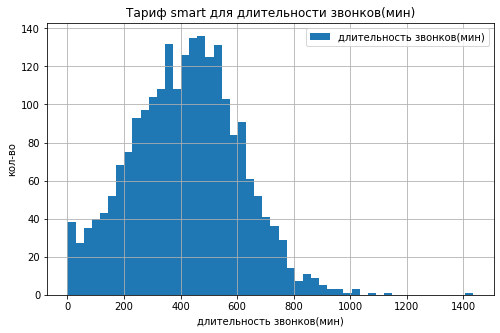

In [61]:
money.loc[money['tariff_name'] == 'smart', 'длительность звонков(мин)'].plot(kind='hist', bins=50, figsize=(8, 5), grid=True, legend=True)
plt.title('Тариф smart для длительности звонков(мин)')
plt.xlabel('длительность звонков(мин)')
plt.ylabel('кол-во');

Теперь для тарифа **ultra**

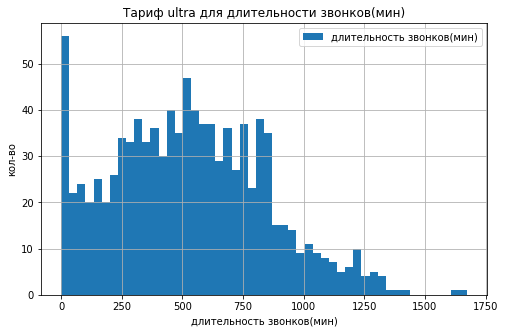

In [62]:
money.loc[money['tariff_name'] == 'ultra', 'длительность звонков(мин)'].plot(kind='hist', bins=50, figsize=(8, 5), grid=True, legend=True)
plt.title('Тариф ultra для длительности звонков(мин)')
plt.xlabel('длительность звонков(мин)')
plt.ylabel('кол-во');

### Сравнительные гистограммы

**Для более наглядной визуальной демонстрации создадим срезы по тарифам `smart` и `ultra` и сравним их. Для этого создадим функцию `func_tariffs` с параметрами:**
* `column` - колонка для которого будет приниматься и делаться гистограмма;
* `bins` - ячейки в гистограмме;
* `range1` - границы для столбца column;
* `figsize` - размер гистограммы;

In [63]:
tariff_smart = money[money['tariff_name'] == 'smart'].reset_index(drop=True) # сохраняем срез и порядок
tariff_ultra = money[money['tariff_name'] == 'ultra'].reset_index(drop=True)

def func_tariffs(column, bins, figsize, range1):
    
    ax = tariff_smart.plot(kind='hist', 
                        y=column, 
                        histtype='step', 
                        range=range1, 
                        bins=bins, 
                        linewidth=2,
                        figsize=figsize,
                        alpha=0.5, 
                        label='по тарифу SMART' + ' ' + column, 
                        grid=True,
                        density = True,
                        legend=True)
    
    tariff_ultra.plot(kind='hist', 
                                y=column, 
                                histtype='step', 
                                range=range1, 
                                bins=bins, 
                                linewidth=2,
                                figsize=figsize,
                                alpha=0.5, 
                                label= 'по тарифу ULTRA' + ' ' + column,
                                ax = ax,        # оси, по которым строится график
                                grid=True,
                                density = True, # это указывает на результат вычислений функции, 
                                                # то есть плотность вероятности на одном графике
                                legend=True
                                )

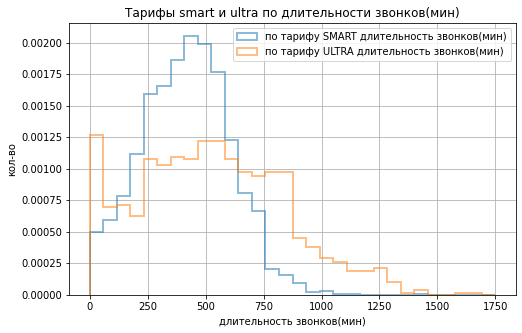

In [64]:
func_tariffs('длительность звонков(мин)', bins=30, figsize=(8, 5), range1=(0, 1750))
plt.title('Тарифы smart и ultra по длительности звонков(мин)')
plt.xlabel('длительность звонков(мин)')
plt.ylabel('кол-во');

#### Вывод по длительности звонков:

Как из группировки, так и по гистограмме видим, что:
* **Cреднее** длительности звонков тарифа **smart** `mean` равно около **`418`**, а тарифа **ultra - `527`**;
* Из группировки и ее функции видим, что **дисперсия** длительности `var` тарифа **`smart`** равна около **`36219`**, а тарифа **`ultra`** около **`1000873`**;
* Также видим, что стандартное отклонение **`std`** тарифа **smart** равно около **190**, а тарифа **ultra** около **317**

**ИТОГ**

* Людям в тарифе **smart** почти израсходуют свой лимит на включенные минуты, а вот в **ultra** расходуют по своим лимитам весьма скромненько. Весьма спорный момент. Может быть просто доплачивать за минуты в другом тарифе? Будем вести дальше анализ для такого вывода, ведь может, что просто другие тратятся весьма бодро, а пока точно известно, что **в среднем пользователям тарифа смарт требуется в месяц примерно 418 минут, а тем, кто на тарифе ультра 527 минут**. 
* **Распределение близко к нормальному** для обоих тарифов, то есть чаще всего встречается среднее значение и близкие к нему, а крайние значения встречаются редко
* Есть **скошенность вправо** небольшого характера у тарифов (`т.к. их медиана меньше среднего`), также у тарифа **ultra** есть смещение вправо, в область больше мин длительности относительно тарифу **smart**
* По правилу **трех стандартных отклонений**, что все значения (`99%`) находятся в промежутке `(mean - 3 * std, mean + 3 * std)` находим: 
  
 Тариф **smart** все значения `длительности звонков` находится в промежутке (**0 - 988** мин);
  
 Тариф **ultra** все значения `длительности звонков` находится в промежутке (**0 - 1478** мин)

#### Потребляемые смс

* Проделаем то же самое и с смс, выстроим функцию вокруг столбца `'кол-во смс за месяц'`:

In [65]:
money_group_messages = money.groupby('tariff_name')['кол-во смс за месяц'].agg(['mean', 'median', 'std', 'var'])
money_group_messages

,mean,median,std,var
tariff_name,,,,
smart,33.384029,28,28.227876,796.812958
ultra,49.363452,38,47.804457,2285.266143


In [66]:
money['кол-во смс за месяц'].describe() # для всех тарифов

count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: кол-во смс за месяц, dtype: float64

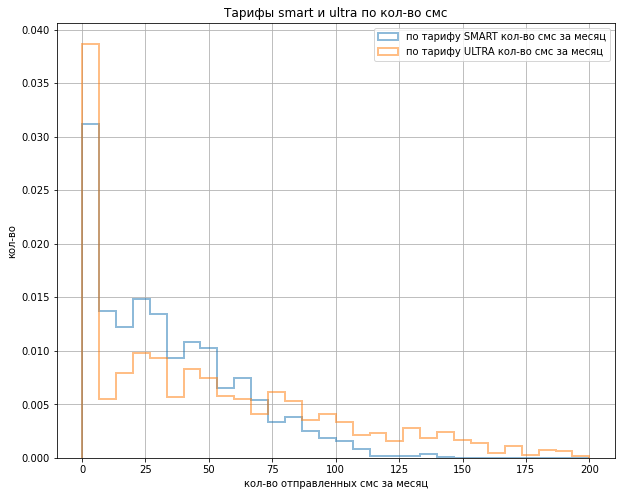

In [67]:
func_tariffs('кол-во смс за месяц', bins=30, figsize=(10, 8), range1=(0, 200))
plt.title('Тарифы smart и ultra по кол-во смс')
plt.xlabel('кол-во отправленных смс за месяц')
plt.ylabel('кол-во');

In [68]:
tariff_smart.loc[tariff_smart['кол-во смс за месяц'] == 0, 'кол-во смс за месяц'].count()

307

In [69]:
tariff_ultra.loc[tariff_ultra['кол-во смс за месяц'] == 0, 'кол-во смс за месяц'].count()

190

##### Вывод по кол-во смс

* Как мы видим, **среднее** тарифа `смарт` - **34** примерно, а тарифа `ультра` - **49**;
* **Дисперсия** тарифа `смарт` равна - **797** примерно, а `ультра` - **2285**;
* `Стандартное отклонение` тарифа `смарт` равно около **28**, а `ультры` - **48**

**Итог**

* Люди не так часто используют смс. Люди практически не отличаются по использованию смс в тарифах. Только вот в ультра чуть более активны в использовании. Очень много людей двух тарифов не используют эту функцию вообще (смс), что мы видим обособление значений вокруг 0
* По гистограмме видим, что присутсвтует небольшое смещение вправо для двух тарифов, но для тарифа **ultra** она более скошена по сравнению с тарифом **smart**, так как его область кол-ва сообщений больше. Небольшое **скошенность вправо** обуславливается меньшей медианой по сравнению со средним
* Распределение более склонно к **распределению Пуассона** (число событий в единицу времени, если они в среднем происходят с измеренной частотой)
* По правилу **трех стандартных отклонений**, что все значения (`99%`) находятся в промежутке `(mean - 3 * std, mean + 3 * std)` находим: 
    
    Тариф **smart** все значения `количества смс` находится в промежутке (**0 - 118** смс);
  
    Тариф **ultra** все значения `количества смс` находится в промежутке (**0 - 193** смс)

#### Объем интернет-трафика потребляемый в месяц

Группируем теперь `'израсходованный интернет(мб)'` по тарифам и все также считаем их **среднее, медиану, стандартное отклонние** и **дисперсию**:

In [70]:
money_group_internet = money.groupby('tariff_name')['израсходованный интернет(мб)'].agg(['mean', 'median', 'var', 'std'])
money_group_internet

,mean,median,var,std
tariff_name,,,,
smart,16229.188425,16531,3.454591e+07,5877.576978
ultra,19486.901523,19324,1.019356e+08,10096.317202


In [71]:
ultra1 = tariff_ultra.loc[tariff_ultra['израсходованный интернет(мб)'] > 30760, 'user_id'].count()
smart1 = tariff_smart.loc[tariff_smart['израсходованный интернет(мб)'] > 15360, 'user_id'].count()
print(f'Число пользователей с превышением лимита своего интернет-трафик тарифа "Ультра": {ultra1}')
print(f'Число пользоветелей с превышением лимита своего интернет-трафик тарифа "Смарт": {smart1}')

Число пользователей с превышением лимита своего интернет-трафик тарифа "Ультра": 134
Число пользоветелей с превышением лимита своего интернет-трафик тарифа "Смарт": 1309


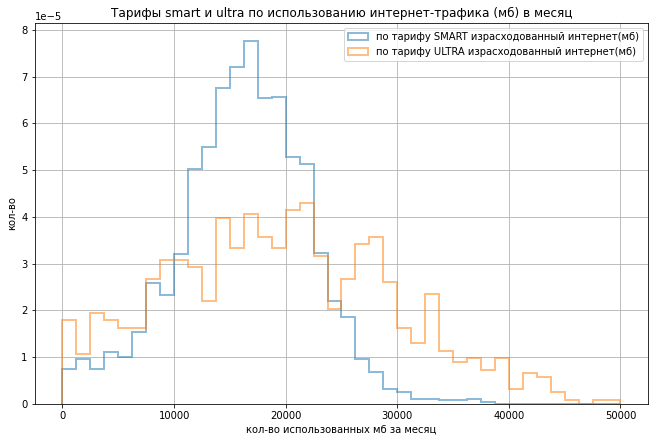

In [72]:
func_tariffs('израсходованный интернет(мб)', bins=40, figsize=(11, 7), range1=(0, 50000))
plt.title('Тарифы smart и ultra по использованию интернет-трафика (мб) в месяц')
plt.xlabel('кол-во использованных мб за месяц')
plt.ylabel('кол-во');

##### Вывод по интернет-трафику

* Как мы видим, **среднее** использованных мб в месяц тарифа `смарт` - **16230** примерно, а тарифа `ультра` - около **19487**;
* **Дисперсия** тарифа `смарт` равна - **34545910** примерно, а `ультра` - **101935600**;
* `Стандартное отклонение` тарифа `смарт` равно около **5877.57**, а `ультры` - **10096.31**

**Итог**

* Люди тарифа **smart** зачастую превышают свой лимит в `15 Гб`. Люди тарифа **ultra** тоже этим не пренебрегают. Присутстсует смещение вправо тарифа **ultra** относительно тарифа **smart**, так как там больше область трафика.
* **Распредление** близко к **нормальному**
* По правилу **трех стандартных отклонений**, что все значения (`99%`) находятся в промежутке `(mean - 3 * std, mean + 3 * std)` находим: 
    
    Тариф **smart** все значения `потребляемых мб в месяц` находится в промежутке (**0 - 33863** мб);
  
    Тариф **ultra** все значения `потребляемых мб в месяц` находится в промежутке (**0 - 49776** мб)

## Проверка гипотез

**Нужно проверить**:
* **№1: Средняя выручка** пользователей тарифов **«Ультра»** и **«Смарт» различаются**;
* **№2: Средняя выручка** пользователей из **Москвы** отличается **от** выручки пользователей из **других регионов**

Сначала взглянем на среднюю суммарную стоимость за месяц двух тарифов:

In [73]:
#money.loc[money['tariff_name'] == 'ultra', 'суммарная стоимость за месяц'].mean()
#money.loc[money['tariff_name'] == 'smart', 'суммарная стоимость за месяц'].mean()
average_proceed = money.groupby('tariff_name')['суммарная стоимость за месяц'].agg(['mean'])
average_proceed

,mean
tariff_name,
smart,1294.63930
ultra,2071.06599


Зафиксировали их. Теперь перед проверкой гипотез нужно избавиться от выбросов, они могут влиять на гипотезы, а точнее на `t-распределения`. Например, методом **3-х сигм** можем их обнаружить, который мы уже проделывали ранее для нужных нам значений 

In [74]:
money.groupby('tariff_name')['суммарная стоимость за месяц'].agg(['mean', 'median', 'std', 'var'])

,mean,median,std,var
tariff_name,,,,
smart,1294.63930,1038,820.933202,673931.321363
ultra,2071.06599,1950,378.802377,143491.240560


In [75]:
print(f'99% значений тарифа "smart" находится до: {1294.63 + 3 * 820.93}')
print(f'99% значений тарифа "ultra" находится до: {2071.06 + 3 * 378.80}')

99% значений тарифа "smart" находится до: 3757.42
99% значений тарифа "ultra" находится до: 3207.46


* Тариф **smart** краевые значения `стоимости за месяц` находятся до **3757** руб;
* Тариф **ultra** краевые значения `стоимости за месяц` находится до **3207** руб

Смотрим на **диаграмму размаха** визуально:

In [76]:
tariff_smart['суммарная стоимость за месяц'].describe()

count    2229.000000
mean     1294.639300
std       820.933202
min       550.000000
25%       550.000000
50%      1038.000000
75%      1750.000000
max      6770.000000
Name: суммарная стоимость за месяц, dtype: float64

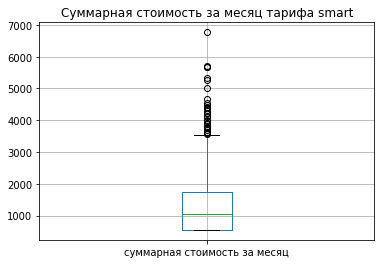

In [77]:
tariff_smart.boxplot('суммарная стоимость за месяц')
plt.title('Суммарная стоимость за месяц тарифа smart');

Наблюдаем, что **межквартильный размах** от `550 до 1750` руб. Тут мы видим, что крайняя точка `2 квартиля` равна около **3750**. Далее считаются выбросами. 

Далее смотрим на "ящик с усами" для тарифа **ultra:**

In [78]:
tariff_ultra['суммарная стоимость за месяц'].describe()

count     985.000000
mean     2071.065990
std       378.802377
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: суммарная стоимость за месяц, dtype: float64

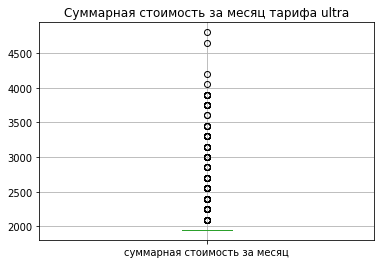

In [79]:
tariff_ultra.boxplot('суммарная стоимость за месяц')
plt.title('Суммарная стоимость за месяц тарифа ultra')
plt.show();

Она более невнятная. Видим, что среднее недалеко ушло от тарифного плана по стоимости за месяц. 

Построим гистограмму по уже проделанной функции для выручки за месяц тарифов:

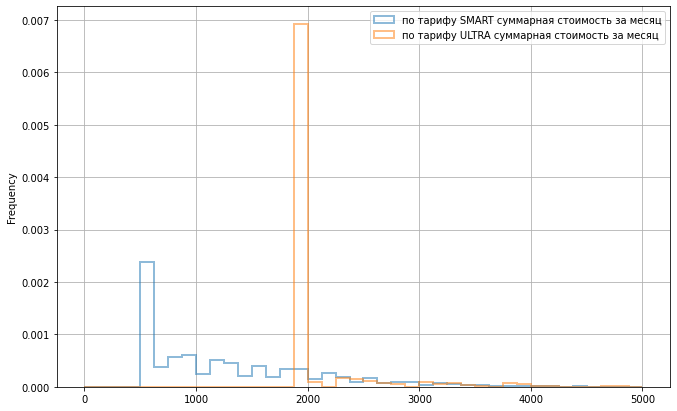

In [80]:
func_tariffs('суммарная стоимость за месяц', bins=40, figsize=(11, 7), range1=(0, 5000))

Хм, пользователи **smart** немного превышают свои лимиты и соотвественно переплачивают. Подробнее в общем выводе напишу об этом

### Формулировка нулевой и альтернативной гипотезы №1

По правилу **3-х сигм** нашли значение для тарифа **ultra**. Теперь создадим срезы без выбросов для двух тарифов и составим нулевую гипотезу и альтернативную, которые гласят:
* **Н0**: средняя выручка пользователей тарифов «Ультра» и «Смарт» `не различаются`
* **Н1**: средняя выручка пользователей тарифов «Ультра» и «Смарт» `различаются`

После сохранения срезов без выбросов, мы группируем по пользователям суммарную стоимость и **считаем среднюю выручку**:

In [81]:
no_emissions_smart = money.loc[(money['tariff_name'] == 'smart')&(money['суммарная стоимость за месяц'] <= 3757), 'суммарная стоимость за месяц'].reset_index(drop=True)
no_emissions_ultra = money.loc[(money['tariff_name'] == 'ultra')&(money['суммарная стоимость за месяц'] <= 3207), 'суммарная стоимость за месяц'].reset_index(drop=True)
#new_no_emissions_smart = no_emissions_smart.groupby('user_id')['суммарная стоимость за месяц'].mean()
#new_no_emissions_ultra = no_emissions_ultra.groupby('user_id')['суммарная стоимость за месяц'].mean()

In [82]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(      # мы используем для проверки гипотезы о равенстве среднего двух генеральных 
                            # совокупностей по взятым из них выборкам st.ttest_ind(array1, array2)
            #Тут выборочные средние нормально распределены (это работает даже если генеральная не распределена нормально). 
    no_emissions_smart,
    no_emissions_ultra,
    )         # указываем дисперсию по умолчанию

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.5720686229620526e-181
Отвергаем нулевую гипотезу


#### Вывод по №1

Все-таки **различаются**. Мы это видим по всем нашим проделанным действиям. Эти различия отличишь `"невооруженным взглядом"`.

###  Формулировка нулевой и альтернативной гипотезы №2 

* **Н0: Средняя выручка** пользователей **из Москвы не отличается** от выручки пользователей из **других регионов**
* **Н1: Средняя выручка** пользователей **из Москвы отличается** от выручки пользователей из других регионов

Сначала **создадим срез** пользователей **из Москвы**, который поместим в переменную **`moscow`**, а других отметим как **другие регионы `another`**(т.к. для выполнения нам не требуется ничего более):

In [83]:
money['city'].value_counts().to_frame()

,city
Москва,611
Санкт-Петербург,270
Новосибирск,98
Уфа,95
Краснодар,86
...,...
Сургут,6
Нижневартовск,6
Кемерово,5
Химки,5


In [84]:
moscow = money[money['city'] == 'Москва']
another = money[money['city'] != 'Москва']
#moscow['city'].value_counts().to_frame()

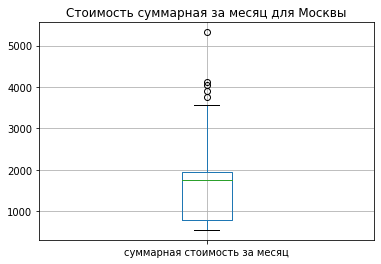

In [85]:
#no_emissions_ultra['city'].value_counts().to_frame()
moscow.boxplot('суммарная стоимость за месяц')
plt.title('Стоимость суммарная за месяц для Москвы');

In [86]:
print(f'для Москвы 99% значений находятся до: {1550.80 + 3 * 752.45}')
print(f'для других региново 99% значений находятся до: {1528.31 + 3 * 810.41}')

для Москвы 99% значений находятся до: 3808.1500000000005
для других региново 99% значений находятся до: 3959.54


Так же, как и ранее перед проверкой гипотез нужно избавиться от выбросов, они могут влиять на гипотезы. Наблюдаем, что **межквартильный размах** от `733 до 1950` руб. Тут мы видим, что крайняя точка `2 квартиля` равна около **3800**. По правилу **3-х сигм** считаем и получаем значения: для Москвы `moscow` около **до 3808**, для других регионов `another` примерно **до 3960**. Далее считаются выбросами

* Создаем срезы с переменными `no_emissions_moscow` и `no_emissions_another`:

In [87]:
moscow['суммарная стоимость за месяц'].describe()

count     611.000000
mean     1550.805237
std       752.451347
min       550.000000
25%       798.000000
50%      1750.000000
75%      1950.000000
max      5321.000000
Name: суммарная стоимость за месяц, dtype: float64

In [88]:
another['суммарная стоимость за месяц'].describe()

count    2603.000000
mean     1528.316942
std       810.411374
min       550.000000
25%       750.000000
50%      1587.000000
75%      1950.000000
max      6770.000000
Name: суммарная стоимость за месяц, dtype: float64

In [89]:
no_emissions_moscow = moscow.loc[moscow['суммарная стоимость за месяц'] <= 3808, 'суммарная стоимость за месяц'].reset_index(drop=True)
no_emissions_another = another.loc[another['суммарная стоимость за месяц'] <= 3959.5, 'суммарная стоимость за месяц'].reset_index(drop=True)
#no_emissions_another['суммарная стоимость за месяц'].describe()
#no_emissions_moscow['суммарная стоимость за месяц'].describe()

По аналогии с предыдущей гипотезой, создаем срезы **средней выручки** пользователей для **Москвы** `no_emissions_moscow_mean` и соответственно для **других регионов `no_emissions_another_mean`** и проверяем гипотезы:

In [90]:
alpha = .05
results = st.ttest_ind(     
    no_emissions_moscow,
    no_emissions_another,
    )         # указываем дисперсию выборок разными 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.37205860390959233
Не получилось отвергнуть нулевую гипотезу


#### Вывод по №2

Результат наших действий показал, что **`не получилось отвергнуть нулевую гипотезу`**. **Вероятность случайно получить** такое или большее различие равно почти **`37%`**. Это слишком большая вероятность, чтобы делать вывод о каком-то значимом различии между средней выручки пользователей Москвы и других регионов.

## Общий вывод

* Мы разобрали данные по выборке пользователей компании 'Мегалайн';
* Преобразовали к нужным типам данные, разобрали пустые значения и заполнили их с разъяснениями(помимо которых были в анотации к проекту `churn_date`);
* Сделали новые колонки, где рассчитаны для каждого пользователя: **`'кол-во звонков'`, `'длительность звонков(мин)'`, `'кол-во смс за месяц'`, `'израсходованный интернет(мб)'`**, а также подсчитали суммарную стоимость за месяц для каждого отдельного клиента тарифа и назвали соотвествующим образом **`суммарная стоимость за месяц`**;
* Привели в порядок данные, путем объединения данных методом `merge()`. Также округлили значения в колонках  `'длительность звонков(мин)'` и `'израсходованный интернет(мб)'` для правильного расчета и более удобной визуальной демонстрации, как идет расчет по тарифу;
* Проделали статистический анализ, по которому рассчитали для созданных колонок `дисперсию (var)`, `стандартное отклонение(std)`. Также выявили **среднее и медианы**, благодаря которым были описаны **распределения**;
* По **гистограмме** внедренную в нашу функцию для подсчета стоимости **разобрали**, что пользователи тарифа **smart** часто `заходят за лимиты` и `переплачивают` свыше абонентской платы. А вот пользователи тарифа **ultra** **укладываются** в свой лимит. Может быть стоит поднять планку лимитов для тарифа **smart**, чтобы людям было комфортнее и не было перехода на другой;
* Если брать кол-во пользователей по двум тарифам и умножить на среднюю выручку, то окажется что тариф **smart** приносит `больше` денег, чем тариф **ultra** в месяц. Все, предполагаю, из-за переплат и большего кол-во пользователей;
* Были выдвинуты гипотезы, которые мы разобрали:
   
   **№1:** **Средняя выручка** пользователей тарифов «Ультра» и «Смарт» **различаются - это оказолось правдой**. Нами были выдвинуты `нулевая` и `альтернативная гипотеза`, вследствии которой мы пришли к данному выводу;
   
   **№2:** **Средняя выручка** пользователей из **Москвы отличается** от выручки пользователей из **других регионов - это оказалость не так**. Более того, они почти равны